In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid'])
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow.keras.models import load_model
from scipy.signal import hilbert
from tqdm import tqdm
tqdm._instances.clear()
## Some Functions
from tensorflow.keras import backend as K

In [3]:
## Plots Setting
Axis_labelSize = 16
LegendFontSize = 12

In [4]:
def GetSignalNoiseWindows(Trace, signalLength=50, noiseLength=400, totalLength=1000, minGap=50):
    '''
    Returns the values where the signal window start and stops and where the nose window starts and stops
    given the location of the middle of the signal.
    '''
    signalMiddle = np.argmax(np.abs(Trace))
#     signalMiddle = np.argmax(np.abs(hilbert(Trace)))
    
    if totalLength <= 0:
        log_warn("The waveform length does not look right! ({})".format(totalLength))

    if signalMiddle >= totalLength:
        log_fatal("The signal middle ({}) is beyond the end of the waveform ({})".format(signalMiddle, totalLength))

    if signalLength + noiseLength + minGap > totalLength:
        log_fatal("You cannot fit a signal window ({}) and noise window ({}) with a gap of ({}) inside a waveform of length ({})". format(
          signalLength, noiseLength, minGap, totalLength))

    signalStart = signalMiddle - int(signalLength / 2)

    if signalStart < 0:
        signalStart = 0

    signalStop = signalStart + signalLength - 1
    if signalStop >= totalLength:
        signalStart -= signalStop - totalLength - 1
        signalStop = totalLength - 1

    #Put the noise window on the side of the signal window with more room
    if signalStart > (totalLength - signalStop): #More room at the beginning
        noiseMid = int((signalStart - minGap)/2)
        noiseStart = max(noiseMid - int(noiseLength/2), 0) #Don't go below zero
        noiseStop = min(noiseStart + noiseLength - 1, signalStart - minGap - 1) #Don't overlap with signal

    else: #More room at the end
        noiseMid = int((totalLength + minGap + signalStop) / 2)
        noiseStart = max(noiseMid - int(noiseLength/2), minGap + signalStop + 1)
        noiseStop = min(noiseStart + noiseLength - 1, totalLength - 1)

    #They should not overlap
    assert(not (signalStart <= noiseStart <= signalStop))
    assert(not (signalStart <= noiseStop <= signalStop))

    return int(signalStart), int(signalStop), int(noiseStart), int(noiseStop)



def GetSNR(Trace):
    '''
    Return the Signal to Noise Ratio. Signal is just the peak of the trace.
    Medain RMS of chunck of trace. 
    '''
#     from scipy.signal import hilbert
    SigPeak = np.max(np.abs((Trace))) # Can also use abs value instead of hilbert 
    Chunks = np.array_split(Trace, 16)  # Split the trace in to 10 small chunks
    ChunkRMS_squared = [(sum(chunk**2))/len(chunk) for chunk in Chunks] ## RMS^2 of each chunk
    RMS_Median = np.median(ChunkRMS_squared) ## Chunk with signal in it.
    return SigPeak**2/RMS_Median 

def CorrCoeff(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = mx
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den
    return r


def Normalize(array):
    normalized_array = np.zeros_like(array)  # Create a new array to store normalized values
    scale_fac = []
    for i in range(array.shape[0]):  # Iterate over samples/events
        max_value = np.max(np.abs(array[i]))  # Calculate the maximum value across both channels
        
        if max_value != 0:  # Avoid division by zero
            normalized_sample = array[i] / max_value
            normalized_array[i] = normalized_sample
        else:
            print("Max vlue 0 encountered at index :", i)
        scale_fac.append(max_value)
    return normalized_array, scale_fac


def GetOutput(Traces, Classifier): ## get the predicted classifier output for the input traces
    Traces = np.array(Traces)
    predict = Classifier.predict(Traces)
    y_predict = predict.reshape(predict.shape[0],)
    return y_predict

def ComputePercentPositives(Bin, Threshold=0.5):
    BinLen = len(Bin)
    Positives = 0
    for i in range(BinLen):
        if Bin[i] >= Threshold:
            Positives += 1
#     print(f"Total Inputs = {BinLen}, Total predict Positives = {Positives}")
    return (Positives / BinLen) * 100


def GetPowerRatio(y_true, y_pred):
    ## Find the Noise and Signal Windows
    signalStart, signalStop, noiseStart, noiseStop = GetSignalNoiseWindows(y_true)
    def Power(voltages):
        ## Get Power in two windows
        signal_window = voltages[signalStart : signalStop]  ## window where the signal should be
        noise_window = voltages[noiseStart : noiseStop]        
 
        E_sig = np.sum(np.array(signal_window)**2) / len(signal_window)
        E_PerBin_noise = np.sum(np.array(noise_window)**2) / len(noise_window)
        return  E_sig - E_PerBin_noise
        
    Pred_Power = Power(y_pred)
    True_Power = Power(y_true)
    return Pred_Power / True_Power

In [5]:
## Directories
ant = "ant1"
month = "MayJune"
data = "test"

## Models Dir
Dir = f"/mnt/janus/arehman/work/2023_Split_months_data-Final/TrainingData_V2/{month}/2D_CNN/Denoiser/"
ClDir = f"/mnt/janus/arehman/work/2023_Split_months_data-Final/{month}/2D_CNN/Classifier/" ## Classifier was not trained again (Since it should not affect)

# Validation Data Dir
DataDir = "/mnt/janus/arehman/work/2023_Split_months_data-Final/MayJune_Validation/V2/Data/"
DataDir_test = f"/mnt/janus/arehman/work/2023_Split_months_data-Final/TrainingData_V2/{month}/2D_CNN/Denoiser/TstTrn/" # For Test set
DenoiserDir = Dir + "Models/"
PlotsDir = DataDir + "Plots/"

import os
if not os.path.exists(PlotsDir):
    os.makedirs(PlotsDir)

## Load Data
## For test
# SigPlusNoise = np.load(DataDir_test + f"{ant}_Noisy_test.npy")
# PureSignals = np.load(DataDir_test + f"{ant}_Signals_test.npy")
## End test

## For Validation set
SigPlusNoise = np.load(DataDir + f"{ant}_Noisy.npy")
PureSignals = np.load(DataDir + f"{ant}_Signals.npy")
Background = np.load(DataDir + f"{ant}_NoiseOnly.npy")

# SNR_SigPlusNoise = np.load(DataDir + "/SNR_SigPlusNoise.npy")
# SNR_Background = np.load(DataDir + "/SNR_Background.npy")

# ## float64 ---> float32
# SigPlusNoise = np.array(SigPlusNoise, dtype='float32')
# Background = np.array(Background, dtype='float32')
# PureSignals = np.array(PureSignals, dtype='float32')

In [6]:
print(f"No. of background traces in test set = {len(Background)} and Noisy traces = {len(SigPlusNoise)}")

No. of background traces in test set = 60000 and Noisy traces = 60000


In [7]:
## Splitting the traces to compute SNR, del it later
SN_ch0, SN_ch1 = SigPlusNoise[:,:,0], SigPlusNoise[:,:,1]
# Sig_ch0, Sig_ch1 = PureSignals[:,:,0], PureSignals[:,:,1]
Noise_ch0, Noise_ch1 = Background[:,:,0], Background[:,:,1]

## SNR Sig+Noise
snr_SN_ch0 = [GetSNR(i) for i in tqdm(SN_ch0)]
snr_SN_ch1 = [GetSNR(i) for i in tqdm(SN_ch1)]

# ## SNR Sig
# snr_Sig_ch0 = [GetSNR(i) for i in Sig_ch0]
# snr_Sig_ch1 = [GetSNR(i) for i in Sig_ch1]

## SNR Noise
snr_Noise_ch0 = [GetSNR(i) for i in tqdm(Noise_ch0)]
snr_Noise_ch1 = [GetSNR(i) for i in tqdm(Noise_ch1)]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:08<00:00, 7288.01it/s]


In [8]:
del SN_ch0, SN_ch1, Noise_ch0, Noise_ch1

In [36]:
SNR_SigPlusNoise = np.concatenate((snr_SN_ch0, snr_SN_ch1))
SNR_Background = np.concatenate((snr_Noise_ch0, snr_Noise_ch1))

In [37]:
print(f" Mean value of background SNR = {np.mean(SNR_Background)}")

 Mean value of background SNR = 41.044101558961714


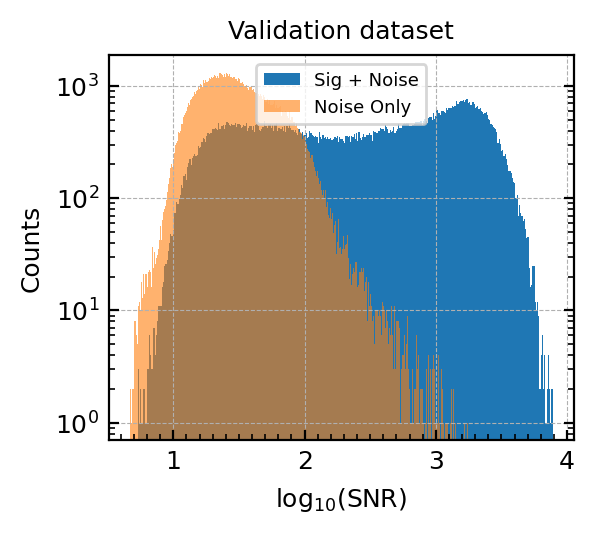

In [18]:
fig = plt.figure(figsize=(3,2.5))
ax = fig.add_subplot(111)

from matplotlib.ticker import MultipleLocator
ax.yaxis.set_minor_locator(MultipleLocator(50))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

ax.hist(np.log10(SNR_SigPlusNoise) ,bins=int(np.sqrt(len(SNR_SigPlusNoise))), alpha=1, label="Sig + Noise")
ax.hist(np.log10(SNR_Background) ,bins=int(np.sqrt(len(SNR_Background))), alpha=0.6, label="Noise Only")

ax.set_title("Validation dataset", fontsize=9)

ax.set_yscale("log")

ax.tick_params(axis='both', which='both', direction='in',labelsize=9)
ax.yaxis.set_ticks_position('both')
ax.yaxis.grid(linestyle="--", linewidth=0.4)
ax.xaxis.grid(linestyle="--", linewidth=0.4)

ax.set_xlabel(r"log$_{10}$(SNR)", fontsize=9)
ax.set_ylabel("Counts", fontsize=9)

plt.legend(loc='best', prop={'size': LegendFontSize});

# Testing

In [44]:
ant = 1
# x_train = np.load(DataDir + f"/ant{ant}_Noisy_train.npy")
x_test = np.load(DataDir + f"/ant{ant}_Noisy_test.npy")

# y_train = np.load(DataDir + f"/ant{ant}_Signals_train.npy")
y_test = np.load(DataDir + f"/ant{ant}_Signals_test.npy")


# x_train = np.array(x_train, dtype='float32')
# x_test = np.array(x_test, dtype='float32')

# y_train = np.array(y_train, dtype='float32')
# y_test = np.array(y_test, dtype='float32')


### Normalizing
def normalize_deno_array(array, y_array):
    normalized_array = np.zeros_like(array)  # Create a new array to store normalized values
    normalized_y_array = np.zeros_like(array)  # Create a new array to store normalized values
    
    scale_fac = []
    for i in range(array.shape[0]):  # Iterate over samples/events
        max_Xvalue = np.max(np.abs(array[i]))  # Calculate the maximum value across both channels
        max_Yvalue = np.max(np.abs(y_array[i]))  # Calculate the maximum value across both channels
        max_value = max(max_Xvalue, max_Yvalue)  # Calculate the maximum value across both channels
        
        if max_value != 0:  # Avoid division by zero
            normalized_sample = array[i] / max_value
            normalized_array[i] = normalized_sample
            
            ## Normalizing labels
            normalized_y_sample = y_array[i] / max_value
            normalized_y_array[i] = normalized_y_sample
            
        else:
            print("Max vlue 0 encountered at index :", i)
        scale_fac.append(max_value)
    return normalized_array, normalized_y_array, scale_fac

Text(0.5, 1.0, 'Noisy ch1')

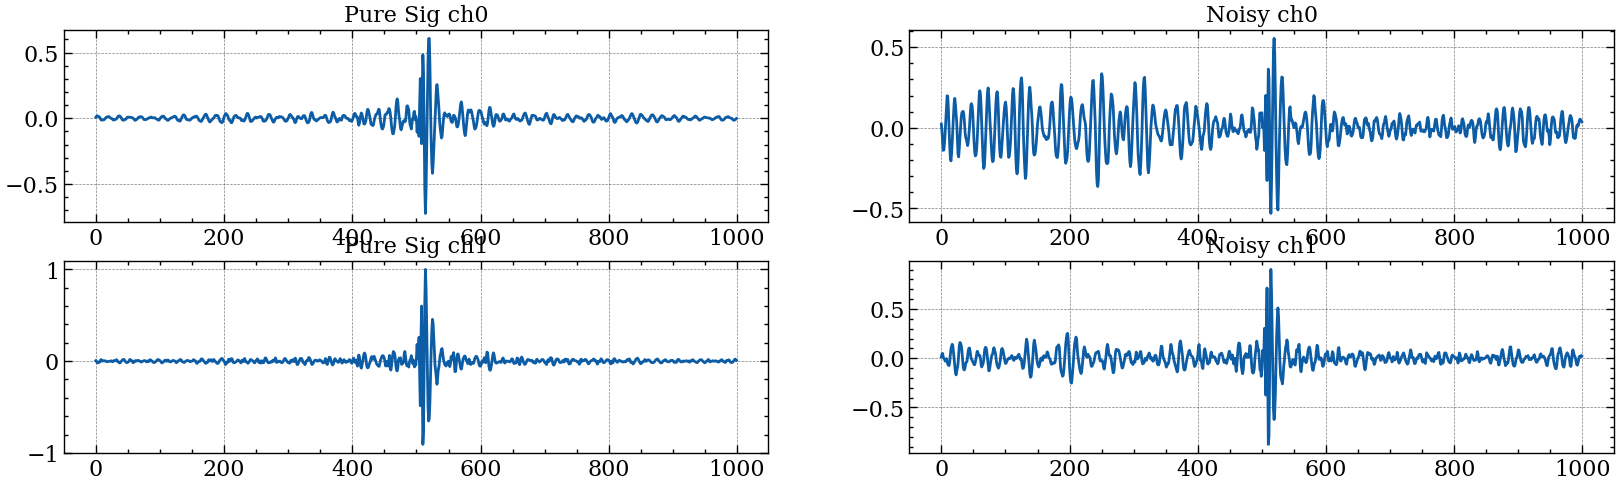

In [47]:
i = 20
fig = plt.figure(figsize=(20,5.5))

ax = fig.add_subplot(221)
ax.plot(Sig_ch0[i])
ax.set_title("Pure Sig ch0")

ax = fig.add_subplot(222)
ax.plot(SN_ch0[i])
ax.set_title("Noisy ch0")

ax = fig.add_subplot(223)
ax.plot(Sig_ch1[i])
ax.set_title("Pure Sig ch1")

ax = fig.add_subplot(224)
ax.plot(SN_ch1[i])
ax.set_title("Noisy ch1")


# End Testing

In [9]:
## Normalizing
SigPlusNoise, SFactor_SigPlusNoise = Normalize(SigPlusNoise)
Background, SFactor_Background = Normalize(Background)

In [10]:
# Ant = "1"
# Ks, lyr = 33, 3
ClassifierDir = ClDir + "Models/"
# model = "Classifier_L=2_Fil=12_KS=160.h5"
model = f"{ant}_fil12_ks45lyr4.h5"
## Load Model
Classifier = load_model(ClassifierDir + model)
## Predicting
sig_out = GetOutput(SigPlusNoise, Classifier)
noise_out = GetOutput(Background, Classifier)

2023-12-04 13:16:32.101953: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 13:16:32.561731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46642 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0, compute capability: 8.6
2023-12-04 13:16:34.797435: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8902
2023-12-04 13:16:35.284974: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [40]:
THR = [0.4, 0.5, 0.6]
FP_Percent = []
for thre in THR:
    fp_percent = ComputePercentPositives(noise_out, thre)
    FP_Percent.append(fp_percent)
    print(f"Thresold = {thre}, False Positive rate = {fp_percent}")

Thresold = 0.4, False Positive rate = 1.7333333333333332
Thresold = 0.5, False Positive rate = 0.8116666666666666
Thresold = 0.6, False Positive rate = 0.4266666666666667


# For Confusion Matrix Plot:

In [14]:
threshold = 0.5
#Get the confusion matrix
Y_true = np.concatenate((np.ones(len(sig_out)), np.zeros(len(noise_out))))

Y_Pred = np.concatenate((sig_out, noise_out))
Y_Pred = (Y_Pred > threshold).astype('float') ## To convert to 0 or 1 for consusion matrix 


from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(Y_true, Y_Pred)
print(cf_matrix)

[[59513   487]
 [ 5841 54159]]


In [24]:
# !conda install -c anaconda seaborn -y   ## To install th package, hope I wont have to do all the time

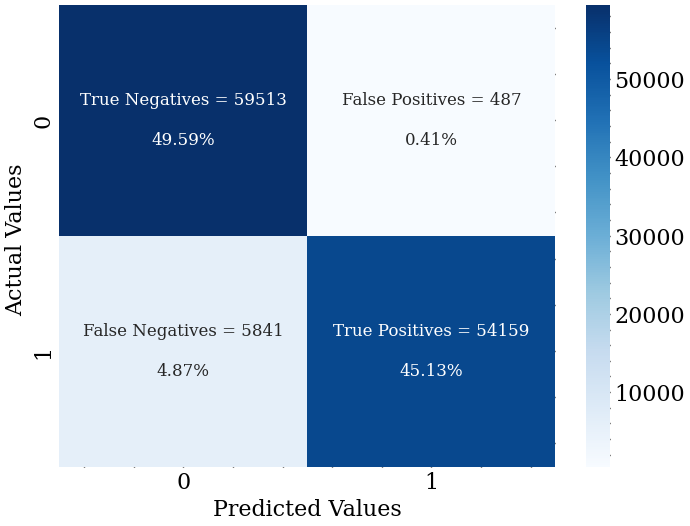

In [148]:
import seaborn as sns
group_names = ["True Negatives","False Positives","False Negatives","True Positives"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1} = {v2}\n\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt="",cmap="Blues", annot_kws={"fontsize":12})
ax.set_xlabel('Predicted Values', fontsize = Axis_labelSize)
ax.set_ylabel('Actual Values ', fontsize = Axis_labelSize)
## Display the visualization of the Confusion Matrix.
plt.savefig(PlotsDir + f"/Confusion_Matrix_{ant}.png", bbox_inches='tight')

# For Other Classifier Plots:

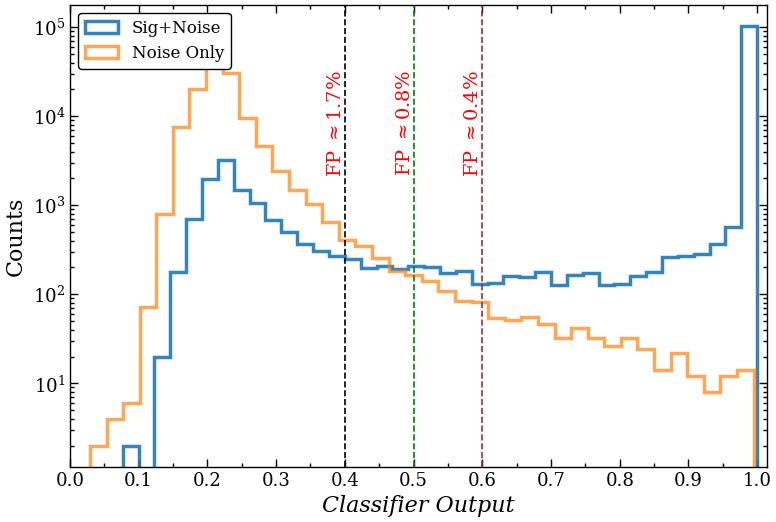

In [94]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)

from matplotlib.ticker import MultipleLocator
ax.yaxis.set_minor_locator(MultipleLocator(1000))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

# ax.grid(True, which="both", ls='--', lw=0.4, c='k', alpha=0.4)

ax.hist(SigOut, bins=40, histtype='step',linewidth=2.5, color="#1f77b4", alpha=0.9, label="Sig+Noise")
ax.hist(NoiseOut, bins=40, histtype='step',linewidth=2.5, color="#ff7f0e", alpha=0.7, label="Noise Only")

ax.set_yscale('log')

for thr, fpp, clr in zip(THR, FP_Percent, ['black', 'green', 'brown']):
    ax.axvline(x=thr,c= clr, ls='--', lw=1.2)
    ax.text(thr, 0.86, r'FP $\approx$'+f'{round(fpp,1)}%', color='red', ha='right', va='top', rotation=90,
                transform=ax.get_xaxis_transform(), fontsize=14)


ax.legend(loc=2, prop={'size': LegendFontSize}, edgecolor='black')

ax.set_xlabel("Classifier Output", fontsize=Axis_labelSize, fontstyle='oblique')
ax.set_ylabel("Counts", fontsize=Axis_labelSize)

ax.grid(False)

ax.set_xlim(0, 1.015)
# ax.set_ylim(0.1, 4e5)

ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
# ax.text(xmax - (xmax - xmin)*0.03, ymin + (ymax - ymin) * 0.55,
#       "IceCube Preliminary", color='r',
#       verticalalignment='bottom', horizontalalignment='right', fontsize=8)

ax.tick_params(axis='both', which='both', direction='in',labelsize=13)
# plt.savefig(PlotsDir + f"/ClassifierOutput_{ant}.png", bbox_inches='tight')

In [41]:
## Giving the scores to both channels, all ch0 1st
SigOut = np.concatenate((sig_out, sig_out))
NoiseOut = np.concatenate((noise_out, noise_out))

In [42]:
## Chossen threshold to compute TP and FP rates, with 99% rejection of background.
CL_threhold = 0.5

#####################################
# True Positives and False Positives
#####################################
## Bin the Sig + Noise data
centers = np.linspace( np.log10(min(SNR_SigPlusNoise)), np.log10(max(SNR_SigPlusNoise))-0.5, 15)

CLOut_Sig = [[] for i in range(len(centers))]  ## Binning the classifier output
SNR_Sig = [[] for i in range(len(centers))]
for i in range(len(SNR_SigPlusNoise)):
    icenter = np.argmin(np.abs(np.log10(SNR_SigPlusNoise[i])-centers))
    CLOut_Sig[icenter].append(SigOut[i])
    SNR_Sig[icenter].append(SNR_SigPlusNoise[i]) 

## For Background binning
centers = np.linspace( np.log10(min(SNR_Background))+0.1, np.log10(max(SNR_Background))-0.2, 8)

CLOut_Noise = [[] for i in range(len(centers))]  ## Classifier output binned
SNR_Noise = [[] for i in range(len(centers))]

for i in range(len(SNR_Background)):
    icenter = np.argmin(np.abs(np.log10(SNR_Background[i])-centers))
    CLOut_Noise[icenter].append(NoiseOut[i])
    SNR_Noise[icenter].append(SNR_Background[i])

## Get TP and FP
TruePositive = []
for Bin in CLOut_Sig:   ## For Sig Traces
    TruePositive.append(ComputePercentPositives(Bin, CL_threhold))
    
FalsePositive = []
for Bin in CLOut_Noise: ## For background
    FalsePositive.append(ComputePercentPositives(Bin, CL_threhold))

#### Bin Centers for x axis (SNR values)
Sig_BinCenters = [np.mean(elem) for elem in SNR_Sig]
Noise_BinCenters = [np.mean(elem) for elem in SNR_Noise]

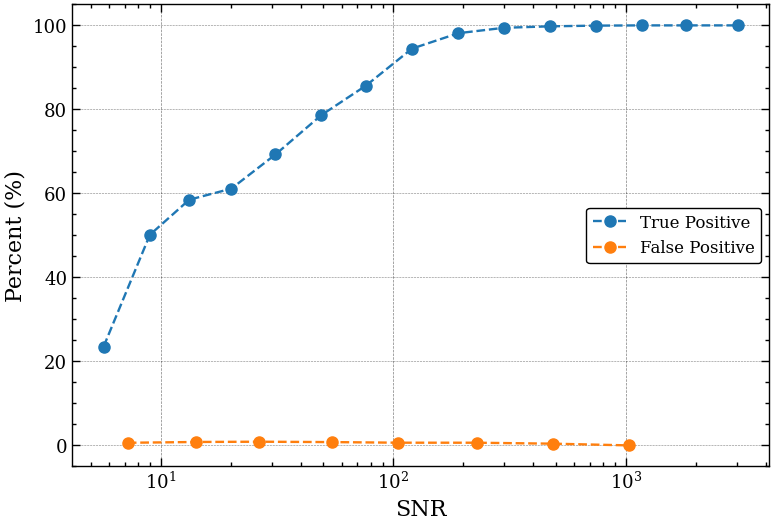

In [43]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)

from matplotlib.ticker import MultipleLocator
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(20))

ax.tick_params(axis='both', which='both', direction='in',labelsize=13);

# ax.grid(True, which="both",ls='--', lw=0.4, c='k', alpha=0.5)
ax.yaxis.grid(True, which='major',ls='--', lw=0.4, c='k', alpha=0.5)

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.plot(Sig_BinCenters, TruePositive, 'o--',c="#1f77b4", lw=1.7, ms=8, label= "True Positive")
ax.plot(Noise_BinCenters, FalsePositive, 'o--', c="#ff7f0e", lw =1.7, ms=8, label= "False Positive")
    
ax.set_xscale('log')

ax.set_xlabel("SNR", fontsize=Axis_labelSize)
ax.set_ylabel("Percent (%)", fontsize=Axis_labelSize)

ax.legend(loc=7, prop={'size': LegendFontSize}, edgecolor='black')

ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
# ax.text(xmax - (xmax - xmin)*0.19, ymin + (ymax - ymin) * 0.78,
#       "IceCube Preliminary", color='r',
#       verticalalignment='bottom', horizontalalignment='right', fontsize=9)

# ax.hlines(0, xmin, xmax, linestyles='dashed',linewidth=0.8, colors='k', alpha=0.5)  

ax.tick_params(axis='both', which='both', direction='in',labelsize=13)
# plt.savefig(PlotsDir + f"/TPFP_vs_SNR_{ant}.png", bbox_inches='tight');

# For Denoiser Plots:

In [11]:
CL_threhold = 0.5
#######################################
## Indx of traces that passes the threshold
ClassifiedIndex = [i for i in range(len(sig_out)) if sig_out[i] > CL_threhold] 
print("Total no of traces = %d " % len(SigPlusNoise))        
print("No of Classified traces = %d " % len(ClassifiedIndex))

Total no of traces = 60000 
No of Classified traces = 54159 


In [12]:
#######################################
## Select only classifierd traces
SigPlusNoise = SigPlusNoise[ClassifiedIndex]
SFactor_SigPlusNoise = np.array(SFactor_SigPlusNoise)[ClassifiedIndex]
PureSignals = PureSignals[ClassifiedIndex]

In [21]:
## If no classifier cuts applied- Scipt can be run from here

In [13]:
## Split the traces agin to calculate the SNR for each channel trace
## Time consuming but good way to keep track of labels
SN_ch0, SN_ch1 = SigPlusNoise[:,:,0], SigPlusNoise[:,:,1]
## SNR Sig+Noise
snr_SN_ch0 = [GetSNR(i) for i in tqdm(SN_ch0)]
snr_SN_ch1 = [GetSNR(i) for i in tqdm(SN_ch1)]
SNR_Measured = np.concatenate((snr_SN_ch0, snr_SN_ch1))

del SN_ch0, SN_ch1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 54159/54159 [00:07<00:00, 7345.12it/s]


In [14]:
DenoiserModel = f"{ant}_fil64_ks33" 

Denoiser = load_model(DenoiserDir + "{0}.h5".format(DenoiserModel), compile=False)
## Predicting
DenoisedWaveforms = Denoiser.predict(SigPlusNoise)

In [15]:
## Rescaling the traces (Denoised and Noisy)
NoisyTraces = np.array([SigPlusNoise[i] * SFactor_SigPlusNoise[i] for i in tqdm(range(len(SigPlusNoise)))])
DenoisedTraces = np.array([DenoisedWaveforms[i] * SFactor_SigPlusNoise[i] for i in tqdm(range(len(DenoisedWaveforms)))])

### Splitting the traces in to channeltraces
SN_ch0, SN_ch1 = NoisyTraces[:,:, 0], NoisyTraces[:,:, 1]
deno_tr_ch0, deno_tr_ch1 = DenoisedTraces[:,:, 0], DenoisedTraces[:,:, 1]
Psig_tr_ch0, Psig_tr_ch1 = PureSignals[:,:, 0], PureSignals[:,:, 1]


### Combining the channel traces in a single array
NoisyTraces = np.concatenate((SN_ch0, SN_ch1))
DenoisedTraces = np.concatenate((deno_tr_ch0, deno_tr_ch1))
PureSignals = np.concatenate((Psig_tr_ch0, Psig_tr_ch1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 54159/54159 [00:00<00:00, 364960.87it/s]


In [16]:
######################
### Finding Peak Times
######################
PeakTime_Noisy = [ np.argmax(np.abs(hilbert(trace))) for trace in tqdm(NoisyTraces) ]
PeakTime_Denoised = [ np.argmax(np.abs(hilbert(trace))) for trace in tqdm(DenoisedTraces) ]
PeakTime_True = [ np.argmax(np.abs(hilbert(trace))) for trace in tqdm(PureSignals) ]

##### Peak Time Difference
PTdiff_TrueMinusRaw = np.array(PeakTime_True) - np.array(PeakTime_Noisy) 
PTdiff_TrueMinusDeno = np.array(PeakTime_True) - np.array(PeakTime_Denoised)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 108318/108318 [00:03<00:00, 27502.26it/s]


In [17]:
########################
### Finding Power Ratios
########################
PowerRatio_Trad = [GetPowerRatio(PureSignals[i], NoisyTraces[i]) for i in tqdm(range(len(PureSignals)))]##(Noisy/True) 
PowerRatio_NN = [GetPowerRatio(PureSignals[i], DenoisedTraces[i]) for i in tqdm(range(len(PureSignals)))]##(Deno/True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 108318/108318 [00:02<00:00, 38085.57it/s]


In [18]:
## Binning the data (with respect to SNR)
# centers = np.linspace( np.log10(min(SNR_Measured))+0.1, np.log10(max(SNR_Measured))-1.0, 10)

Leftcent = np.linspace( np.log10(min(SNR_Measured))+0.1, np.log10(100), 8)
Rightcent = np.linspace( np.log10(100)+0.2, np.log10(max(SNR_Measured))-0.2, 4)

centers = list(Leftcent) + list(Rightcent)

PtDiff_Trad = [[] for i in range(len(centers))] ## Peak Time Difference
PtDiff_NN = [[] for i in range(len(centers))]

PWRRatio_Trad = [[] for i in range(len(centers))] ## Power Ratio
PWRRatio_NN = [[] for i in range(len(centers))]

SNRBinned = [[] for i in range(len(centers))]

for i in tqdm(range(len(SNR_Measured))):
    icenter = np.argmin(np.abs(np.log10(SNR_Measured[i])-centers))
    
    PtDiff_Trad[icenter].append(PTdiff_TrueMinusRaw[i])
    PtDiff_NN[icenter].append(PTdiff_TrueMinusDeno[i])
    
    PWRRatio_Trad[icenter].append(PowerRatio_Trad[i])
    PWRRatio_NN[icenter].append(PowerRatio_NN[i])
    
    SNRBinned[icenter].append(SNR_Measured[i])

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 108318/108318 [00:00<00:00, 161856.81it/s]


In [22]:
def GetStats(array):
    ## Calculate the median and 68%
    array.sort()
    median = array[int(len(array)*0.5)]
    OneSigma = array[int(len(array)*0.84)] - array[int(len(array)*0.16)]
    YerrHigh = array[int(len(array)*0.84)] - array[int(len(array)*0.5)]
    YerrLow =  array[int(len(array)*0.5)] - array[int(len(array)*0.16)]
    return median, OneSigma, YerrHigh, YerrLow

In [19]:
def GetStatsNumpy(array):
    ## Calculate the median and 68%
    array_sorted = np.sort(array)
    median = np.median(array_sorted) ### Mean (Median)
    percentile_16 = np.percentile(array_sorted, 16)
    percentile_84 = np.percentile(array_sorted, 84)
    
    OneSigma = percentile_84 - percentile_16  ### 68% containment
    YerrHigh = percentile_84 - median ## difference from the medain
    YerrLow = median - percentile_16 ## difference from the medain
    
    return median, OneSigma, YerrHigh, YerrLow

In [20]:
## Computing the stats
SNRBinCenters = [np.median(elem) for elem in SNRBinned]
####################### Arrival Time Diff ######################################
### Traditional
TdiffMean_Trad, TdiffStd_Trad = [], []
YerrLow, YerrHigh = [], []
for entry in PtDiff_Trad:
    median, sigma, yer_High, yer_Low = GetStatsNumpy(entry)
    entry.sort() ## Sorting
    TdiffMean_Trad.append( median ) ### Mean (Median)
    TdiffStd_Trad.append( sigma ) ### 68% containment
    YerrHigh.append( yer_High ) ## difference from the medain
    YerrLow.append( yer_Low ) ## difference from the medain

### NN Method
TdiffMean_NN, TdiffStd_NN = [], []
YerrLow_NN, YerrHigh_NN = [], []
for entry in PtDiff_NN:
    median, sigma, yer_High, yer_Low = GetStatsNumpy(entry)
    TdiffMean_NN.append( median ) ### Mean (Median)
    TdiffStd_NN.append( sigma ) ### 68% containment
    YerrHigh_NN.append( yer_High ) ## difference from the medain
    YerrLow_NN.append( yer_Low )## difference from the medain

####################   Power Ratio ############################################
### Traditional
PowerRatioMean_Trad, PowerRatioStd_Trad = [], []
elow, ehigh =[], []
for entry in PWRRatio_Trad:
    median, sigma, yer_High, yer_Low = GetStatsNumpy(entry)
    PowerRatioMean_Trad.append( median )
    PowerRatioStd_Trad.append( sigma )
    ehigh.append( yer_High )
    elow.append( yer_Low )
    
### NN Method
PowerRatioMean_NN, PowerRatioStd_NN = [], []
elowNN, ehighNN =[], []
for entry in PWRRatio_NN:   ### NN method
    median, sigma, yer_High, yer_Low = GetStatsNumpy(entry)
    PowerRatioMean_NN.append( median )
    PowerRatioStd_NN.append( sigma )
    ehighNN.append( yer_High )
    elowNN.append( yer_Low )
################################################################

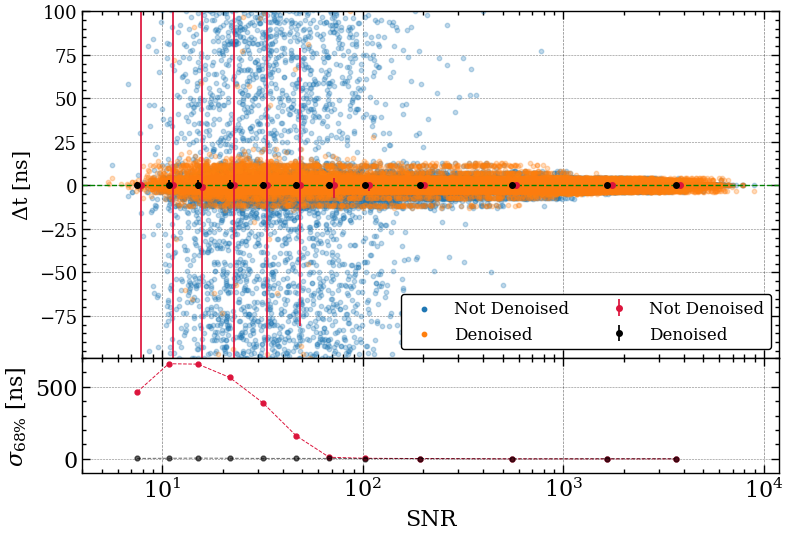

In [21]:
from matplotlib.ticker import MultipleLocator


gs = gridspec.GridSpec(2, 1, wspace=0.025, hspace=0, width_ratios=[1], height_ratios=[0.75, 0.25])
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(gs[0])
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(axis='both', which='both', direction='in',labelsize=13)

Circlesize=10
ErrorCircle=8.0
Elinewidth=1.25

ax.scatter(SNR_Measured, PTdiff_TrueMinusRaw,c="#1f77b4",  s=Circlesize, alpha=0.28)
ax.scatter(SNR_Measured, PTdiff_TrueMinusDeno, c="#ff7f0e", s=Circlesize, alpha=0.28)
ax.scatter([], [], c='#1f77b4', s=Circlesize, label='Not Denoised') ## For showing the labels, remove the earlier label
ax.scatter([], [], c='#ff7f0e', s=Circlesize, label='Denoised') ## For showing the labels, remove the earlier label

ax.errorbar(np.array(SNRBinCenters)*1.05, TdiffMean_Trad, yerr=[YerrLow, YerrHigh], c='crimson',  fmt='.',ms = ErrorCircle, elinewidth=Elinewidth,\
            label='Not Denoised')
ax.errorbar(SNRBinCenters, TdiffMean_NN, yerr=[YerrLow_NN, YerrHigh_NN], c='k',  fmt='.',ms=ErrorCircle, elinewidth=Elinewidth, label='Denoised')

ax.yaxis.set_ticks_position('both') ## Positions of ticks
ax.xaxis.set_ticks_position('both')


ax.set_xscale('log')
ax.set_ylim(-99,100)

ax.set_ylabel(r"$\Delta$t [ns]", fontsize=15)

# ax.grid(True, which="both", axis='both', ls='--', lw=0.3, c='k', alpha=0.5)
ax.legend(loc='best', prop={'size': LegendFontSize}, ncol=2,  edgecolor='black')

ax.set_xticklabels([])

# ymin, ymax = ax.get_ylim()
# xmin, xmax = ax.get_xlim()
# ax.text(xmax - (xmax - xmin)*0.19, ymin + (ymax - ymin) * 0.16,
#       "IceCube Preliminary", color='r',
#       verticalalignment='bottom', horizontalalignment='right', fontsize=8)

ax.yaxis.grid(True, which='major',ls='--', lw=0.4, c='k', alpha=0.5)
ax.axhline(0, ls='dashed', lw=1, color='g')

Xlim = (10**0.6, max(SNR_Measured)+3000)
ax.set_xlim(Xlim)

ax = fig.add_subplot(gs[1])
ax.set_xscale('log')

# ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
# ax.yaxis.set_ticks_position('both')

ax.yaxis.grid(True, which='major',ls='--', lw=0.4, c='k', alpha=0.5)


## For setting minor ticks
import matplotlib
# y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
# ax.yaxis.set_minor_locator(y_minor)
# ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

## For setting manual ticks
# ax.yaxis.set_ticks([1, 10, 100])
# ax.set_yticklabels(['1', '10','100'])


ax.plot(SNRBinCenters, TdiffStd_Trad, 'o--', lw=0.7, c='crimson', markersize=3.5, alpha=1)
ax.plot(SNRBinCenters, TdiffStd_NN, 'o--', lw=0.7, c='k', markersize=3.5, alpha=0.6)


ax.set_ylim(-100, 700)
ax.set_xlim(Xlim)



ax.set_xlabel("SNR", fontsize=Axis_labelSize)
ax.set_ylabel(r"$\sigma_{\rm 68\%}$ [ns]", fontsize=Axis_labelSize);

# plt.savefig('./TimeDiff.pdf' , bbox_inches='tight');

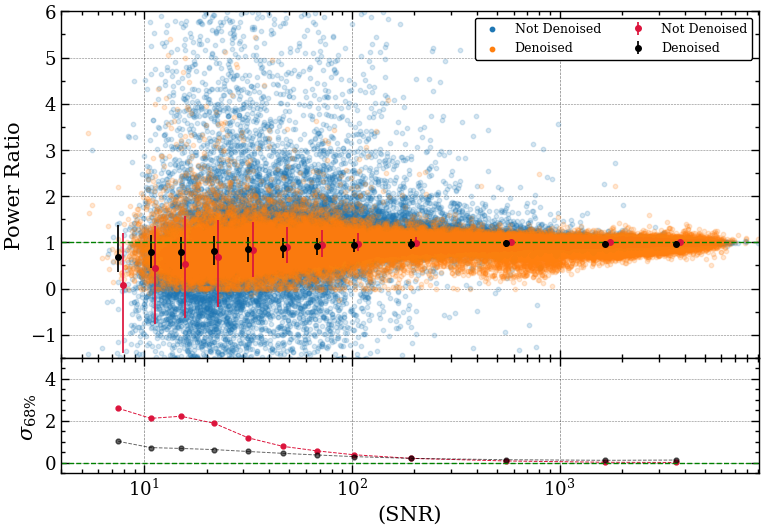

In [22]:
from matplotlib.ticker import MultipleLocator

gs = gridspec.GridSpec(2, 1, wspace=0.025, hspace=0, width_ratios=[1], height_ratios=[0.75, 0.25])
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(gs[0])
ax.tick_params(axis='both', which='both', direction='in',labelsize=13)
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.scatter(SNR_Measured, PowerRatio_Trad,c="#1f77b4",s=10, alpha=0.18)
ax.scatter(SNR_Measured, PowerRatio_NN, c="#ff7f0e",s=10, alpha=0.18)
ax.scatter([], [],c="#1f77b4", s=10, label='Not Denoised') ## For showing the labels, remove the earlier label
ax.scatter([], [], c="#ff7f0e", s=10, label='Denoised') ## For showing the labels, remove the earlier label

ax.errorbar(np.array(SNRBinCenters)*1.05, PowerRatioMean_Trad, yerr=[elow, ehigh], c='crimson', elinewidth=Elinewidth,  fmt='.',ms = ErrorCircle,label='Not Denoised')
ax.errorbar(SNRBinCenters, PowerRatioMean_NN, yerr=[elowNN, ehighNN], c='k', elinewidth=Elinewidth,  fmt='.',ms = ErrorCircle, label='Denoised')

ax.axhline(1.0, ls='dashed', lw=1, color='g')


ax.set_xscale('log')
ax.set_ylim(-1.5,6)
ax.set_xlim(10**0.6, max(SNR_Measured)+100)
ax.set_ylabel("Power Ratio", fontsize=15)
ax.legend(loc='best', prop={'size': 9}, ncol=2,  edgecolor='black')

ax.tick_params(axis='both', which='both', direction='in',labelsize=13);

# ax.grid(True, which="both", axis='both', ls='--', lw=0.3, c='k', alpha=0.5)
ax.yaxis.grid(True, which='major',ls='--', lw=0.4, c='k', alpha=0.5)


ax.set_xticklabels([])

# ymin, ymax = ax.get_ylim()
# xmin, xmax = ax.get_xlim()
# ax.text(xmax - (xmax - xmin)*0.19, ymin + (ymax - ymin) * 0.16,
#       "IceCube Preliminary", color='r',
#       verticalalignment='bottom', horizontalalignment='right', fontsize=8)



ax = fig.add_subplot(gs[1])
ax.xaxis.set_minor_locator(MultipleLocator(10))

ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_ticks_position('both')

ax.tick_params(axis='both', which='both', direction='in',labelsize=13);

ax.plot(SNRBinCenters, PowerRatioStd_Trad, 'o--', lw=0.7,c='crimson', markersize=3.5,alpha=1)
ax.plot(SNRBinCenters, PowerRatioStd_NN, 'o--', lw=0.7,c='k', markersize=3.5,alpha=0.6)
ax.set_yticks([0,2,4])
# ax.grid(True, which="both", axis='both', ls='--', lw=0.3, c='k', alpha=0.5)
ax.yaxis.grid(True, which='major',ls='--', lw=0.4, c='k', alpha=0.5)

ax.axhline(0.0, ls='dashed', lw=1, color='g')

ax.set_xscale('log')
ax.set_ylim(-0.5,5.0)
ax.set_xlim(10**0.6, max(SNR_Measured)+100)
ax.set_xlabel("(SNR)", fontsize=15)
ax.set_ylabel(r"$\sigma_{\rm 68\%}$ ", fontsize=15);
# plt.savefig('./PowerRatio.pdf' , bbox_inches='tight');

In [ ]:
Ind = []
for i in range(len(SNR_Measured)):
#     if SNR_Measured[i] > 1*10**3 and SNR_Measured[i] < 4*10**1:
    if SNR_Measured[i] > 8*10**1 and SNR_Measured[i] < 2*10**2:
        if PTdiff_TrueMinusDeno[i] < 2:
#             if PowerRatio_NN[i] > 0.95 and PowerRatio_NN[i] < 1.05:
            if PowerRatio_NN[i] > 0 and PowerRatio_NN[i] < 0.50:
                Ind.append(i)
print(Ind[:5])

In [27]:
denoisedSig = DenoisedTraces
SigPlusNoise = NoisyTraces
# PureSignals 

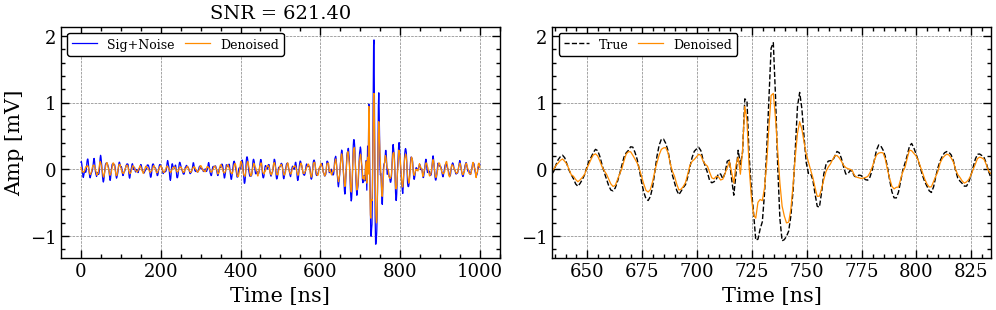

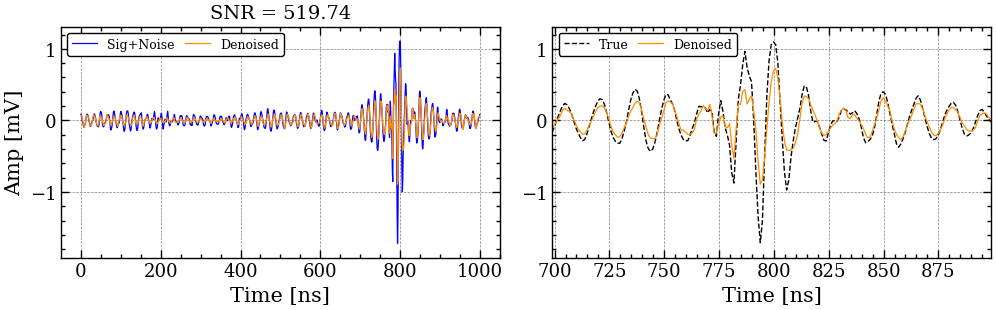

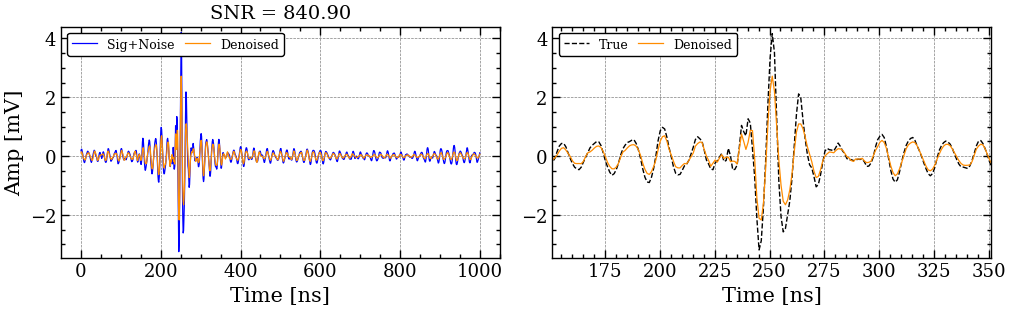

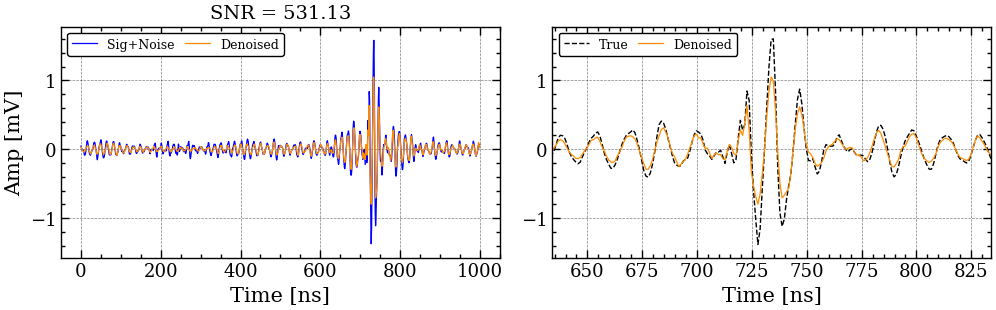

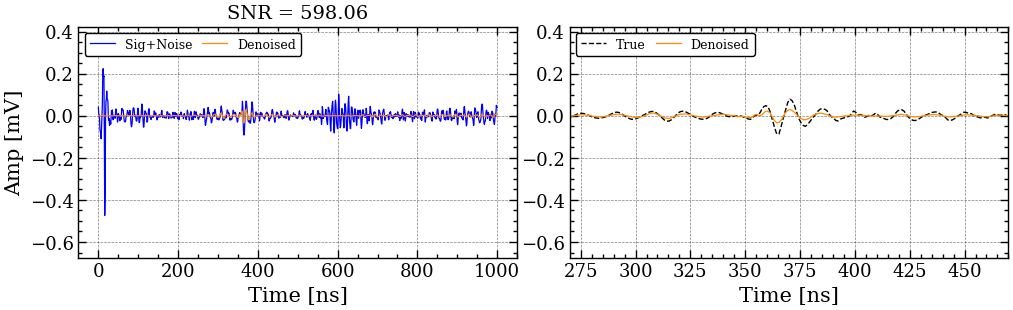

In [29]:
from matplotlib.ticker import MultipleLocator

for i in Ind[:5]:

    snr = SNR_Measured[i]

    NRows, NCols = 1, 2
    gs = gridspec.GridSpec(NRows, NCols, wspace=0.12, hspace=0.3)
    fig = plt.figure(figsize=(6*NCols, 3*NRows))
    ax = fig.add_subplot(gs[0])

    Y1, Y2 = np.array(SigPlusNoise[ i ])/1e-12, np.array(denoisedSig[ i ])/1e-12  # --> In mV
    
    X1= np.linspace(0, 1000, len(Y1))

    
    ax.set_title("SNR = {:.2f}".format(snr), fontsize=14)
    ax.plot(X1, Y1 , c='blue',lw=0.9, label="Sig+Noise")
    ax.plot(X1, Y2 , c='darkorange',lw=0.9, label="Denoised")

    ax.legend(loc='upper left', prop={'size': 9}, ncol=2,  edgecolor='black', columnspacing=0.8)
    ax.set_xlabel("Time [ns]", fontsize=15)
    ax.set_ylabel("Amp [mV]", fontsize=15)
    
#     ax.yaxis.set_minor_locator(MultipleLocator(0.5))
#     ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
#     ax.yaxis.grid(linestyle="--")
#     ax.grid(True, which="both", axis='both', ls='--', lw=0.3, c='k', alpha=0.6)
    
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
    
    
    Ymin, Ymax =  min(Y1)-0.2, max(Y1)+0.2
    ax.set_ylim( Ymin ,  Ymax )
    
    
#     ymin, ymax = ax.get_ylim()
#     xmin, xmax = ax.get_xlim()
#     ax.text(xmax - (xmax - xmin)*0.02, ymin + (ymax - ymin) * 0.91,
#           "IceCube Preliminary", color='r',
#           verticalalignment='bottom', horizontalalignment='right', fontsize=9)
##############################################################################################
########### 2nd Column
    ax = fig.add_subplot(gs[1])
    
    Y1, Y2 = np.array(PureSignals[ i ])/1e-12 , np.array(DenoisedTraces[ i ])/1e-12
#     Y1, Y2 = np.array(PureSignals[ i ]) , np.array(denoisedSig[ i ])
    X1= np.linspace(0, 1000, len(Y1))
    
    
    ax.plot(X1, Y1 ,"--", c='k', lw=1.0, alpha=1, label="True")
    ax.plot(X1, Y2 , c='darkorange', lw=0.9, alpha=1, label="Denoised")

    ax.legend(loc='upper left', prop={'size': 9}, ncol=2,  edgecolor='black', columnspacing=0.8)
    ax.set_xlabel("Time [ns]", fontsize=15)
    ###### x-limit 
    signal_middle = np.argmax( Y1 )
    
    ax.set_xlim( signal_middle-100, signal_middle+100 )

    ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')

#     ax.yaxis.set_minor_locator(MultipleLocator(0.5))
#     ax.xaxis.set_minor_locator(MultipleLocator(5))
#     ax.grid(True, which="both", axis='both', ls='--', lw=0.3, c='k', alpha=0.6)
    
    ax.set_ylim( Ymin ,  Ymax )
    
#     ymin, ymax = ax.get_ylim()
#     xmin, xmax = ax.get_xlim()
#     ax.text(xmax - (xmax - xmin)*0.02, ymin + (ymax - ymin) * 0.91,
#           "IceCube Preliminary", color='r',
#           verticalalignment='bottom', horizontalalignment='right', fontsize=9)
#     plt.savefig('./Eg1.pdf' , bbox_inches='tight');    

# Test Plots

In [23]:
def GetSpectra(trace):
    fft_result = np.fft.fft(trace)
    n = len(trace)
    Spec = np.abs(fft_result[:n//2])

    return np.array(Spec)

In [24]:
def MakePlot(noisy, denoised, pure):
    fig = plt.figure(figsize=(16,7.5))
    ax = fig.add_subplot(221)
    ax.plot(noisy/1e-12, c='blue', lw=0.8,alpha=0.9, label="Noisy")
    ax.plot(denoised/1e-12,c='darkorange',alpha=0.6, label="Denoised")
    ax.legend(fontsize=12)
    
    ax = fig.add_subplot(222)
    ax.plot(pure/1e-12,"--", c='k', label="Pure Signal")
    ax.plot(denoised/1e-12, c='darkorange', lw=0.9, label="Denoised")
    ax.legend(fontsize=12)
    
    signal_middle = np.argmax( pure )
    ax.set_xlim( signal_middle-60, signal_middle+60 )
    
    ax = fig.add_subplot(223)
    ax.plot( GetSpectra(noisy)/1e-9, c='blue', label="Noisy Spectrum")
    ax.plot( GetSpectra(denoised)/1e-9, c='darkorange',alpha=0.6, label="Denoised Spectrum")
    ax.legend(fontsize=12)
    ax.set_xlim( 40, 370 )
    

    ax = fig.add_subplot(224)
    ax.plot( GetSpectra(pure)/1e-9, c='blue', lw=1.5, label="Pure Spectrum")
    ax.plot( GetSpectra(denoised)/1e-9, c='darkorange', lw=1.9,alpha=0.6, label="Denoised Spectrum")
    ax.legend(fontsize=12)
   
    ax.set_xlim( 40, 370 )

In [32]:
ToPlot = 0
test_noisy =NoisyTraces[Ind[ToPlot]]
test_denoised = DenoisedTraces[Ind[ToPlot]]
test_pure = PureSignals[Ind[ToPlot]]

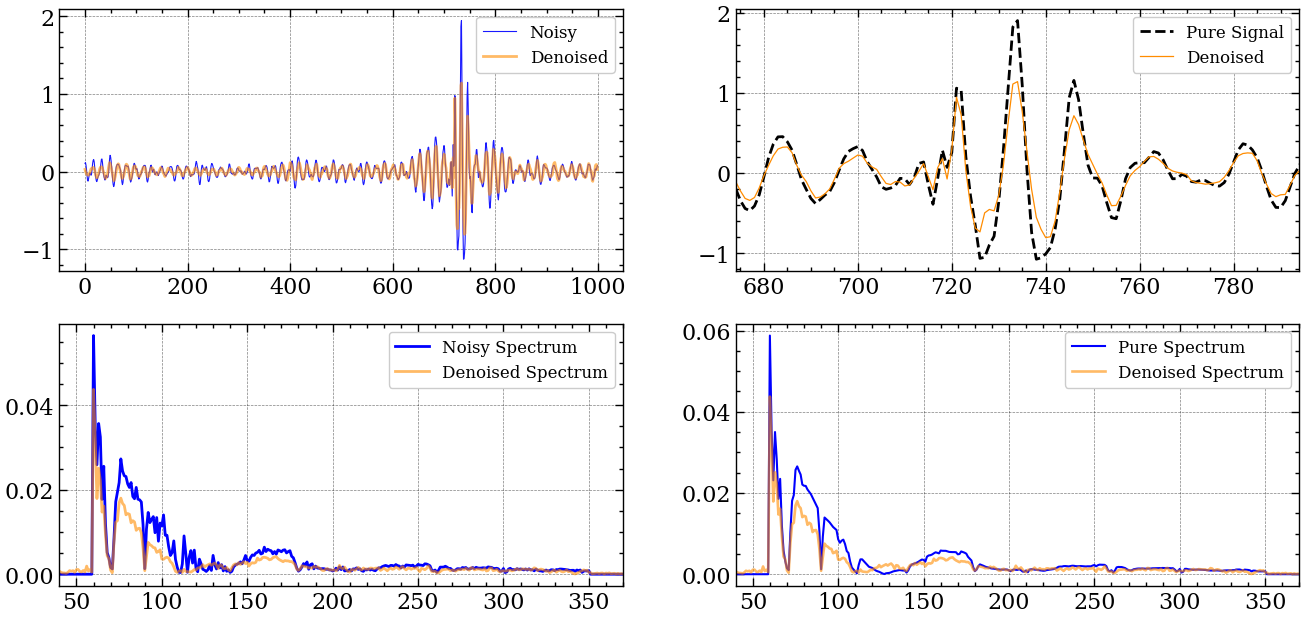

In [33]:
MakePlot(test_noisy, test_denoised,  test_pure)

# End Test Plots

In [ ]:
Ind = []
for i in range(len(SNR_Measured)):
    if PowerRatio_NN[i] < 0.6:
        Ind.append(i)

In [ ]:

from matplotlib.ticker import MultipleLocator

for i in Ind[:5]:

    snr = SNR_Measured[i]

    NRows, NCols = 1, 2
    gs = gridspec.GridSpec(NRows, NCols, wspace=0.12, hspace=0.3)
    fig = plt.figure(figsize=(6*NCols, 3*NRows))
    ax = fig.add_subplot(gs[0])

    Y1, Y2 = np.array(NoisyTraces[ i ])/1e-12, np.array(DenoisedTraces[ i ])/1e-12  # --> In mV
    X1= np.linspace(0, 1000, len(Y1))
    
    ax.set_title("SNR = {:.2f}".format(snr), fontsize=14)
    ax.plot(X1, Y1 , c='blue',lw=0.9, label="Sig+Noise")
    ax.plot(X1, Y2 , c='darkorange',lw=0.9, label="Denoised")

    ax.legend(loc='upper left', prop={'size': 9}, ncol=2,  edgecolor='black', columnspacing=0.8)
    ax.set_xlabel("Time [ns]", fontsize=15)
    ax.set_ylabel("Amp [mV]", fontsize=15)
    
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
#     ax.grid(True, which="both", axis='both', ls='--', lw=0.3, c='k', alpha=0.6)
    
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
    
    
    Ymin, Ymax =  min(Y1)-0.5, max(Y1)+0.5
    ax.set_ylim( Ymin ,  Ymax )
    
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.text(xmax - (xmax - xmin)*0.02, ymin + (ymax - ymin) * 0.905,
          "IceCube Preliminary", color='r',
          verticalalignment='bottom', horizontalalignment='right', fontsize=9)
##############################################################################################
########### 2nd Column
    ax = fig.add_subplot(gs[1])
    
    Y1, Y2 = np.array(PureSignals[ i ])/1e-12 , np.array(DenoisedTraces[ i ])/1e-12
    X1= np.linspace(0, 1000, len(Y1))
    
    ax.plot(X1, Y1 ,"--", c='k', lw=1.0, alpha=1, label="True")
    ax.plot(X1, Y2 , c='darkorange', lw=0.9, alpha=1, label="Denoised")
    

    ax.legend(loc='upper left', prop={'size': 9}, ncol=2,  edgecolor='black', columnspacing=0.8)
    ax.set_xlabel("Time [ns]", fontsize=15)
    ###### x-limit 
    signal_middle = np.argmax( Y1 )
    ax.set_xlim( signal_middle-150, signal_middle+150 )

    ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')

    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(MultipleLocator(5))
#     ax.grid(True, which="both", axis='both', ls='--', lw=0.3, c='k', alpha=0.6)
    
    ax.set_ylim( Ymin ,  Ymax )
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.text(xmax - (xmax - xmin)*0.02, ymin + (ymax - ymin) * 0.905,
          "IceCube Preliminary", color='r',
          verticalalignment='bottom', horizontalalignment='right', fontsize=9)
#     plt.savefig('./Eg1.pdf' , bbox_inches='tight');    

In [ ]:
### Time difference > 5ns

Ind = []
for i in range(len(SNR_Measured)):
    if SNR_Measured[i] < 1*10**2:
        if PowerRatio_NN[i] > 0.9 and PowerRatio_NN[i] < 1.1:
            if PTdiff_TrueMinusDeno[i] > 10:
                Ind.append(i)

In [ ]:
indice = 2
Y1, Y2 = np.array(PureSignals[ Ind[indice] ])/1e-12 , np.array(DenoisedTraces[ Ind[indice] ])/1e-12

In [ ]:
hilEnv_True = np.abs(hilbert(Y1))
hilEnv_Denoised = np.abs(hilbert(Y2))

hilTime_True =  np.argmax(np.abs(hilbert(Y1)))
hilTime_Denoised = np.argmax(np.abs(hilbert(Y2)))

print(f'Peak Time True = {hilTime_True} and Denoised = {hilTime_Denoised}')
print(f'Peak Time Difference = {hilTime_True - hilTime_Denoised} which is equivalent to = {(hilTime_True - hilTime_Denoised)}')

In [ ]:
from matplotlib.ticker import MultipleLocator

for i in Ind[2:3]:

    snr = SNR_Measured[i]

    NRows, NCols = 1, 2
    gs = gridspec.GridSpec(NRows, NCols, wspace=0.3, hspace=0.3)
    fig = plt.figure(figsize=(6*NCols, 3*NRows))
    ax = fig.add_subplot(gs[0])

    Y1, Y2 = np.array(NoisyTraces[ i ])/1e-12, np.array(DenoisedTraces[ i ])/1e-12  # --> In mV
    X1= np.linspace(0, 1000, len(Y1))
    
    
    ax.set_title("SNR = {:.2f}".format(snr), fontsize=14)
    ax.plot(X1, Y1 , c='blue',lw=0.9, label="Sig+Noise")
    ax.plot(X1, Y2 , c='darkorange',lw=0.9, label="Denoised")

    ax.legend(loc='upper left', prop={'size': 9}, ncol=2,  edgecolor='black')
    ax.set_xlabel("Time [ns]", fontsize=15)
    ax.set_ylabel("Amp [mV]", fontsize=15)
    
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(MultipleLocator(50))
    ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
#     ax.grid(True, which="both", axis='both', ls='--', lw=0.3, c='k', alpha=0.6)
    
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
    
    
#     Ymin, Ymax =  min(Y1)-1, max(Y1)+1
    Ymin, Ymax =  min(Y1)-0.1, max(Y1)+0.1
    ax.set_ylim( Ymin ,  Ymax )
##############################################################################################
########### 2nd Column
    ax = fig.add_subplot(gs[1])
    
    Y1, Y2 = np.array(PureSignals[ i ])/1e-12 , np.array(DenoisedTraces[ i ])/1e-12
    
    ax.plot( Y1 ,"--", c='k', lw=1.0, alpha=1, label="True")
    ax.plot( Y2 , c='darkorange', lw=0.9, alpha=1, label="Denoised")
    
    ax.plot( hilEnv_True , ls='dotted', c='blue', lw=1, alpha=1, label="Henv T")
    ax.plot( hilEnv_Denoised , ls='dotted', c='red', lw=1, alpha=1, label="H env D")
    
#     ax.axvline(x= hilTime_True, ymin=Ymin, ymax=Ymax, ls='--', c='blue', lw=1)
#     ax.axvline(x= hilTime_Denoised, ymin=Ymin, ymax=Ymax, ls='--', c='red' , lw=1)

    ax.axvline(x= hilTime_True, ls='--', c='blue', lw=1)
    ax.axvline(x= hilTime_Denoised, ls='--', c='red' , lw=1)

    ax.legend(loc='upper right', prop={'size': 8}, ncol=2,  edgecolor='black', borderpad=0.3, labelspacing=0.3, handletextpad=0.1)
    ax.set_xlabel("Time Bins", fontsize=15)
    ###### x-limit 
    signal_middle = np.argmax( Y1 )
    ax.set_xlim( signal_middle-150, signal_middle+150 )

    ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')

    ax.yaxis.set_minor_locator(MultipleLocator(0.5))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
#     ax.grid(True, which="both", axis='both', ls='--', lw=0.3, c='k', alpha=0.6)
    
    ax.set_ylim( Ymin ,  Ymax )
    
#     plt.savefig('./Eg1.pdf' , bbox_inches='tight');    

In [ ]:
NRows, NCols = 1, 1
gs = gridspec.GridSpec(NRows, NCols, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=(7*NCols, 3*NRows))
ax = fig.add_subplot(gs[0])


Y1, Y2 = np.array(PureSignals[ Ind[indice] ])/1e-12 , np.array(DenoisedTraces[ Ind[indice] ])/1e-12
X1= np.linspace(0, 1000, len(Y1))

Ymin, Ymax =  min(Y1)-0.1, max(Y1)+0.1
ax.set_ylim( Ymin ,  Ymax )

ax.set_title(f'Peak Time Difference = {(hilTime_True - hilTime_Denoised)} ns')

ax.plot(X1, Y1 ,"--", c='k', lw=1.0, alpha=1, label="True")
ax.plot(X1, Y2 , c='darkorange', lw=0.9, alpha=1, label="Denoised")

ax.plot(X1, hilEnv_True , ls='dotted', c='blue', lw=1, alpha=1, label="Envelope True")
ax.plot(X1, hilEnv_Denoised , ls='dotted', c='red', lw=1, alpha=1, label="Envelope Denoised")

# ax.axvline(x= hilTime_True, ymin=Ymin, ymax=Ymax, ls='--', c='blue', lw=1)
# ax.axvline(x= hilTime_Denoised, ymin=Ymin, ymax=Ymax, ls='--', c='red' , lw=1)

ax.plot(hilTime_True, np.max(hilEnv_True),marker='o', c='blue', markersize=4)
ax.plot(hilTime_Denoised, np.max(hilEnv_Denoised),marker='o', c='red', markersize=4)



ax.legend(loc='upper right', prop={'size': 8}, ncol=2,  edgecolor='black', columnspacing=0.8)
ax.set_ylabel("Amp [mV]", fontsize=15)
ax.set_xlabel("Time [ns]", fontsize=15)
###### x-limit 
signal_middle = np.argmax( Y1 )
ax.set_xlim( signal_middle-160, signal_middle+200 )

ax.tick_params(axis='both', which='both', direction='in',labelsize=13);
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(5))
# ax.grid(True, which="both", axis='both', ls='--', lw=0.3, c='k', alpha=0.6)

ax.set_ylim( Ymin ,  Ymax )

ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()
ax.text(xmax - (xmax - xmin)*0.02, ymin + (ymax - ymin) * 0.06,
      "IceCube Preliminary", color='r',
      verticalalignment='bottom', horizontalalignment='right', fontsize=9);